# This notebook is a recreation of the previous notebook with joined tags. Instead of vectorizing each word in a single tag each tag is counted as a single word. 
The following steps were taken to process and model the text data: combined tags, combined text columns, regex, lemmatize, stopwords, saved to csv, reread csv and dropped nulls, modeling.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [2]:
# reading in original dataset
full_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kivamix.csv')

In [3]:
# keeping only columns I want
full_kiva = full_kiva[['LOAN_ID', 'COUNTRY_NAME', 'STATUS', 'DESCRIPTION_TRANSLATED', 'LOAN_USE', 'TAGS']]

In [4]:
# creating dataframe of only loans from Kenya
kiva = full_kiva[full_kiva['COUNTRY_NAME']=='Kenya']

In [5]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51170 entries, 7 to 419149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  50025 non-null  object
 4   LOAN_USE                50025 non-null  object
 5   TAGS                    43157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [6]:
# null scores
kiva['STATUS'].value_counts(normalize=True)

1    0.784659
0    0.215341
Name: STATUS, dtype: float64

### Cleaning and preprocessing text data.

In [7]:
# filling nulls with blank spaces so they aren't erased when combined
kiva = kiva.fillna(' ')

In [8]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51170 entries, 7 to 419149
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51170 non-null  object
 4   LOAN_USE                51170 non-null  object
 5   TAGS                    51170 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [9]:
# removing spaces within tags and creating new column w/changes to TAGS
kiva['processed_TAGS'] = [row.replace(' ', '') for row in kiva['TAGS']]

In [10]:
# removing dashes within tags 
kiva['processed_TAGS'] = [row.replace('-', '') for row in kiva['processed_TAGS']]

In [11]:
# creating column with all text included
kiva['all_text'] = (kiva['DESCRIPTION_TRANSLATED']+kiva['LOAN_USE']+kiva['processed_TAGS'])

In [12]:
# removing html breaks
kiva['all_text'] = kiva['all_text'].str.replace('<br />', ' ')

In [16]:
kiva['all_text'].head()

7     Dinnah is 43 years of age and a proud mother o...
16    Resy is a married woman and has been blessed w...
21    Lavenda is happily married and has been blesse...
41    Hadija is a Kiva borrower. She describes herse...
57    Purity, aged 28, is a lovely mother of two chi...
Name: all_text, dtype: object

In [17]:
# Removing punctuation from text
tokenizer = RegexpTokenizer('\w+|\$[\d.]+|S+')
kiva['all_text'] = [tokenizer.tokenize(row.lower()) for row in kiva['all_text']]

In [18]:
# removing s's from ends of words to be able to count singulars and plurals together
lemmatizer = WordNetLemmatizer()
kiva['all_text'] = [[lemmatizer.lemmatize(token) for token in token_list] for token_list in kiva['all_text']]

In [19]:
# removing most common english words from text
kiva['all_text'] = [[token for token in token_list if token not in stopwords.words('english')] for token_list in kiva['all_text']]

In [20]:
kiva.isnull().sum()

LOAN_ID                   0
COUNTRY_NAME              0
STATUS                    0
DESCRIPTION_TRANSLATED    0
LOAN_USE                  0
TAGS                      0
processed_TAGS            0
all_text                  0
dtype: int64

In [26]:
# rejoining list of words in each row
kiva['joined_text'] = [' '.join(row) for row in kiva['all_text']]

In [28]:
# saving processed dataset to new csv for later use
kiva.to_csv('/Users/precious/dsi/Group-Project/kenya_joined_tags_full_text.csv', index=False)

In [105]:
# new_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kiva_kenya_processed.csv')

In [29]:
kiva.isnull().sum()

LOAN_ID                   0
COUNTRY_NAME              0
STATUS                    0
DESCRIPTION_TRANSLATED    0
LOAN_USE                  0
TAGS                      0
processed_TAGS            0
all_text                  0
joined_text               0
dtype: int64

In [27]:
kiva.head(1)

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,processed_TAGS,all_text,joined_text
7,1799331,Kenya,1,Dinnah is 43 years of age and a proud mother o...,to buy farm inputs such as seeds and fertilize...,#Parent,#Parent,"[dinnah, 43, year, age, proud, mother, 5, 4, s...",dinnah 43 year age proud mother 5 4 school goi...


In [4]:
# rereading in data to remove nulls
processed_kiva = pd.read_csv('/Users/precious/dsi/Group-Project/kenya_joined_tags_full_text.csv')

In [5]:
processed_kiva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51170 entries, 0 to 51169
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51170 non-null  int64 
 1   COUNTRY_NAME            51170 non-null  object
 2   STATUS                  51170 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51170 non-null  object
 4   LOAN_USE                51170 non-null  object
 5   TAGS                    51170 non-null  object
 6   processed_TAGS          43157 non-null  object
 7   all_text                51170 non-null  object
 8   joined_text             51019 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.5+ MB


In [6]:
# dropping nulls from column being used for modeling
processed_kiva.dropna(subset=['joined_text'], axis=0, inplace=True)

In [7]:
processed_kiva.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51019 entries, 0 to 51169
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   LOAN_ID                 51019 non-null  int64 
 1   COUNTRY_NAME            51019 non-null  object
 2   STATUS                  51019 non-null  int64 
 3   DESCRIPTION_TRANSLATED  51019 non-null  object
 4   LOAN_USE                51019 non-null  object
 5   TAGS                    51019 non-null  object
 6   processed_TAGS          43157 non-null  object
 7   all_text                51019 non-null  object
 8   joined_text             51019 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.9+ MB


### EDA and Modeling Joined Text w/Joined Tags

In [10]:
X = processed_kiva['joined_text']
y = processed_kiva['STATUS']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [12]:
# null model scores
y.value_counts(normalize=True)

1    0.784041
0    0.215959
Name: STATUS, dtype: float64

In [15]:
# vectorizing text with 1,2 ngrams and 10,000 max features instead of 20,000 from previous notebook
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=10_000)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [16]:
X_train_tvec.shape

(38264, 10000)

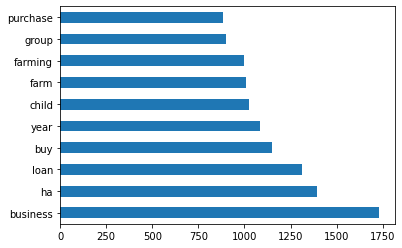

In [17]:
# top-occurring words
X_train_tvec_df = pd.DataFrame(X_train_tvec.todense(),
                         columns=tvec.get_feature_names())

X_train_tvec_df.sum().sort_values(ascending = False).head(10).plot(kind='barh');

The above chart shows the most occuring words in all of the combined text for both funded and expired loans. We can interpret this as most loan requests are to purchase or buy things for a business that includes a farm or farming. 

In [27]:
# top-occurring words separated by status
success_df = pd.DataFrame(tvec.fit_transform(processed_kiva['joined_text'][processed_kiva['STATUS'] == 1]).todense(),
                         columns=tvec.get_feature_names())

expired_df = pd.DataFrame(tvec.fit_transform(processed_kiva['joined_text'][processed_kiva['STATUS'] == 0]).todense(),
                         columns=tvec.get_feature_names())

In [28]:
# creating dataframes of top 15 words for either funded or expired 
top_success = success_df.sum().sort_values(ascending = False).head(15)
top_expired = expired_df.sum().sort_values(ascending = False).head(15)

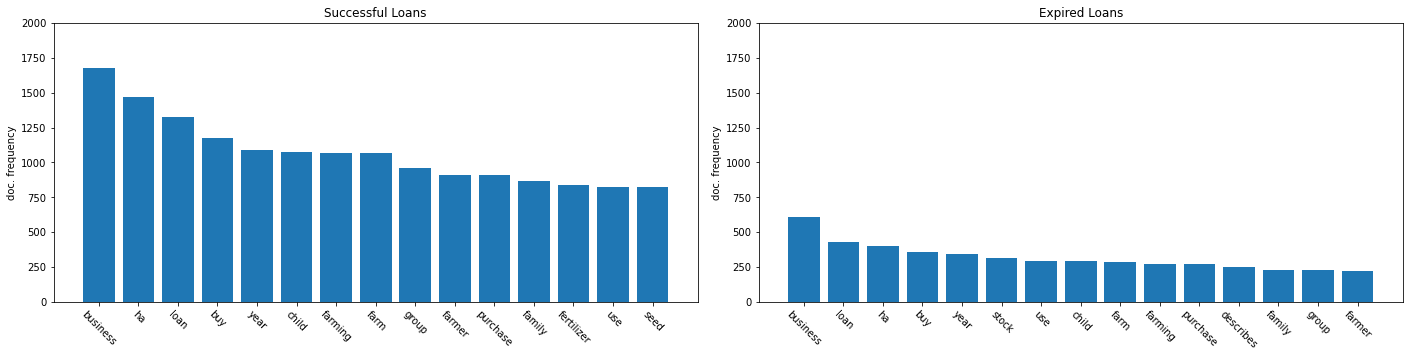

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5));
fig.tight_layout(pad =3)

ax1.bar(top_success.index, top_success);
ax1.set(title='Successful Loans', ylabel='doc. frequency');
ax1.tick_params('x', labelrotation=-45); 
ax1.set_ylim([0, 2000]);
ax2.bar(top_expired.index, top_expired);
ax2.set(title='Expired Loans', ylabel = 'doc. frequency');
ax2.tick_params('x', labelrotation=-45); 
ax2.set_ylim([0, 2000]);


The above charts show us the most frequently used words for funded/successful loans and expired loans. Most of the words are the same for both categories. Mentioning a child, family or group is common. Also mentioning business, farm, farming or farmer. This tells me that most of the people in Kenya who are using kiva.org for loan funding are using it to help their agricultural businesses.

In [31]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tvec, y_train)

LogisticRegression(max_iter=1000)

In [32]:
# scoring logistic regression (ngram1,2, max_feat10_000
print(f'Train score: {logreg.score(X_train_tvec, y_train)}')
print(f'Test score: {logreg.score(X_test_tvec, y_test)}')

Train score: 0.8373928496759356
Test score: 0.8214817718541748


In [33]:
# creating predictions from test data
logreg_preds = logreg.predict(X_test_tvec)

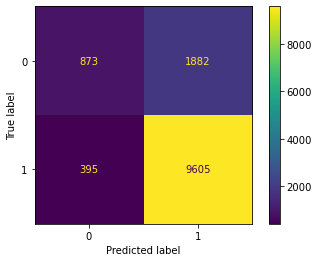

In [34]:
# showing predictions vs true status where 0=expired and 1=funded
logreg_cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(logreg_cm).plot();

In [41]:
print(f'ROC AUC: {roc_auc_score(y_test, logreg_preds)}')
print(f'Cross Val Score: {cross_val_score(logreg, X_train_tvec, y_train, cv=3).mean()}')

ROC AUC: 0.6386892014519057
Cross Val Score: 0.8163809445126128


In [36]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.69      0.32      0.43      2755
           1       0.84      0.96      0.89     10000

    accuracy                           0.82     12755
   macro avg       0.76      0.64      0.66     12755
weighted avg       0.80      0.82      0.79     12755



In [37]:
# creating dataframe of coefs
word_coef_df = pd.DataFrame({'coefs': logreg.coef_[0], 'features': tvec.get_feature_names()})

In [39]:
# top 20 features and their coefficients
word_coef_df.nlargest(20, 'coefs')

,coefs,features
63,5.614132,150
125,3.470010,26
5237,3.381368,kilimo microfinance
8565,3.338394,sirisia district
62,3.326476,15 year
9441,3.211537,use part
8558,3.091468,singleparent
9743,2.488434,wheat barley
47,2.448559,120 000
5230,2.440288,kilimo construct


In [40]:
# lowest 20 features and their coefficients
word_coef_df.nsmallest(20, 'coefs')

,coefs,features
27,-4.320953,10 solar
26,-4.180876,10 liter
6045,-3.664855,mark
7910,-3.484908,respect
7893,-3.371616,residence since
954,-3.265535,bondo
6921,-3.145058,part one
52,-2.864306,130
51,-2.810579,13 year
38,-2.748698,110


### Exploring Where and When Classification Errors Occur (Adapted from Rachel Insler's Code)

In [42]:
# Create DataFrame with column for true values.
results = pd.DataFrame(y_test)

#add in predictions
results['preds'] = (logreg.predict(X_test_tvec))
results.head()

,STATUS,preds
16990,1,1
31018,0,0
18123,1,1
7946,1,1
28,1,1


In [43]:
# Find all indices where predicted and true results aren't the same, then save in an array.
row_ids = results[results['STATUS'] != results['preds']].index
print(row_ids[0:15])

Int64Index([12158, 18920, 38469, 24123, 27421, 43418,  9468, 30459, 24915,
            41858, 25476,  5192, 14418, 46311, 36241],
           dtype='int64')


In [77]:
#Create a dataframe of the misclassified descriptions  
misclassified = processed_kiva.loc[row_ids]

In [78]:
misclassified.shape

(2277, 9)

In [79]:
misclassified.head(2)

,LOAN_ID,COUNTRY_NAME,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,processed_TAGS,all_text,joined_text
12158,1739103,Kenya,0,Prisca is a 51-year-old mom with three lovely ...,to buy hybrid seeds and nutrient-rich fertiliz...,"#Woman-Owned Business, #Parent, #Elderly","#WomanOwnedBusiness,#Parent,#Elderly","['prisca', '51', 'year', 'old', 'mom', 'three'...",prisca 51 year old mom three lovely school goi...
18920,1456198,Kenya,0,“When you are born in the ghetto and in a poor...,to buy farm inputs such as fertilizer and seed...,"user_favorite, #Parent","user_favorite,#Parent","['born', 'ghetto', 'poor', 'family', 'doe', 'l...",born ghetto poor family doe limit achieving go...


In [80]:
# misclassified by status
misclassified['STATUS'].value_counts(normalize=True)

0    0.826526
1    0.173474
Name: STATUS, dtype: float64

In [49]:
#create a dictionary with the probability that a loan will be funded
predict_proba_dict = {'probability (success)' : logreg.predict_proba(X_test_tvec)[:,1],
                     'prediction' : logreg.predict(X_test_tvec),
                     'actual' : y_test,
                     'post_text' : X_test}

In [50]:
#turn it into a dataframe 
predict_proba_df = pd.DataFrame(predict_proba_dict)

#### False Negatives

In [51]:
#look at misclassified loans with the lowest probability of being funded
predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').head(10)

,probability (success),prediction,actual,post_text
23292,0.053010,0,1,george married man ha two child describes hone...
10864,0.096266,0,1,peter married man ha three child describes hon...
29092,0.098941,0,1,william 74 year old retail shop proprietor ken...
29127,0.102617,0,1,joshua married man ha four child describes hon...
28398,0.106273,0,1,michael 25 year old married man ha one child d...
6674,0.135162,0,1,mealii married woman ha 3 child describes ambi...
25314,0.137802,0,1,simon married man describes honest operates bo...
35725,0.141321,0,1,david married man one child describes honest o...
33771,0.143040,0,1,evans 31 year old married two child ha transpo...
22599,0.146833,0,1,peter married man six child describes goal ori...


In [52]:
fns = predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').head(10).index

#### False Positives

In [53]:
#look at misclassified loans with the highest probability of being funded
predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').tail(10)

,probability (success),prediction,actual,post_text
6783,0.959069,1,0,wonderful kiva lender get know alice alice har...
14208,0.960943,1,0,florence single woman five school going child ...
40159,0.961394,1,0,hello meet consolata thirty seven year old sin...
17338,0.962723,1,0,lilian hardworking woman ha defied common thin...
43839,0.964882,1,0,lady raising hand photo salome 52 year old mar...
20860,0.965406,1,0,irene farmer remote town nandihills area kenya...
16862,0.977246,1,0,lilian ha previously benefited kiva loan since...
34624,0.980640,1,0,santa single woman ha child owns house ha neit...
13248,0.984920,1,0,person raising hand photo joshua member mornin...
7756,0.991991,1,0,mike 32 year old married life wife three child...


In [54]:
fps = predict_proba_df.query('prediction != actual').sort_values(by='probability (success)').tail(10).index

### Exploring Complete Text of Misclassified Loan Desciptions

In [81]:
desc_list = [processed_kiva['DESCRIPTION_TRANSLATED'][i] for i in df.index if  i in  misclassified.index]
index_list = [i for i in df.index if i in misclassified.index]
status_list = [processed_kiva['STATUS'][i] for i in df.index if  i in  misclassified.index]

In [82]:
misclassified_df = pd.DataFrame(list(zip(index_list, desc_list, status_list)),columns=['LOAN_ID','DESCRIPTION_TRANSLATED', 'TRUE_STATUS']).set_index('LOAN_ID')

In [85]:
misclassified_df.head()

,DESCRIPTION_TRANSLATED,TRUE_STATUS
LOAN_ID,,
20,Constantine is a smallholder farmer residing i...,0
22,"Clinton is 38 years old, and he is married and...",0
37,"Featured in the above picture is Alfred, who h...",0
93,Victor is in his second year of his studies at...,0
158,Margaret (51) has always emerged victorious de...,0


#### Text from Some of the Loans Classified as False Negatives

In [86]:
fn_df = pd.DataFrame(misclassified_df['DESCRIPTION_TRANSLATED'][fns])
for i in fn_df['DESCRIPTION_TRANSLATED']:
    print(i)
    print(" ")

George is a married man. He has two children. He describes himself to be honest. He operates a motorcycle where he provides transportation services. He has been involved in this business for four years. His business is located in a good area and his primary customers are locals. He describes his biggest business challenge to be inadequate working capital. <br /><br />He will use the KES 100,000 loan to buy another motorcycle to  boost his services for more incomes. Previous loans were repaid successfully. He will use the anticipated profits to open a spare parts shop
 
Peter is a married man. He has three children. He describes himself to be honest. He operates a motorcycle where he provides transportation services. He has been involved in this business for five years. His business is located in a good area, and his primary customers are locals. <br /><br />He describes his biggest business challenge to be inadequate working capital. He will use the KES 50,000 loan to buy another motor

#### Text from Some of the Loans Classified as False Positives

In [87]:
fp_df = pd.DataFrame(misclassified_df['DESCRIPTION_TRANSLATED'][fps])
for i in fp_df['DESCRIPTION_TRANSLATED']:
    print(i)
    print(" ")

Wonderful Kiva lenders, <br /><br />Get to know Alice! Alice is very hardworking. She hails from a remote village in the Kericho area of Kenya. This area has tough living conditions and to survive you must have tough skin. Alice, amongst the women of Kericho, has defied the odds and has been engaged in farming for the past six years. Her primary sources of income are poultry, vegetables, crops and animal farming. <br /><br />Alice is content with the farming way of life. The Kericho area has favorable conditions for horticulture farming and that is why Alice is seeking a loan to buy seeds and start horticulture farming. Because of the good roads, a good climate and a good transportation network, she is sure that she will reap maximum profits and be able to increase her business. <br /><br />Alice, together with her family, is so grateful for your help and contribution.
 
Florence is a single woman with five school-going children. They live in a rental house that has electricity and pip